# Data Description:
Amazon Reviews data ( data source ) The repository has several datasets. For this case study, we are using the Electronics dataset.

# Domain:
E-commerce

# Context:
Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

# Attribute Information:
- userId : Every user identified with a unique id
- productId : Every product identified with a unique id
- Rating : Rating of the corresponding product by the corresponding user
- timestamp : Time of the rating ( ignore this column for this exercise)

# Learning Outcomes:
- Exploratory Data Analysis
- Creating a Recommendation system using real data
- Collaborative filtering

# Objective:
Build a recommendation system to recommend products to customers based on the their previous ratings for other products.


# Steps and tasks:

## 1. Read and explore the given dataset. 
(Rename column/add headers, plot histograms, find data characteristics) 

In [1]:
!pip install scikit-surprise

In [2]:
import pandas as pd
import numpy as np
import os
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
ratings_raw = pd.read_csv("dataset/ratings_Electronics.csv")  
ratings_raw.head() 

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [4]:
ratings_raw.shape

(7824481, 4)

In [5]:
df = pd.read_csv("dataset/ratings_Electronics.csv",  sep=",",  names=["user_id", "product_id", "rating", "timestamp"])

In [6]:
df.head()

,user_id,product_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [7]:
df.shape

(7824482, 4)

In [8]:
df.drop(['timestamp'], axis=1, inplace=True)

In [9]:
df.shape

(7824482, 3)

In [10]:
df.describe()

,rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     object 
 1   product_id  object 
 2   rating      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


<AxesSubplot:>

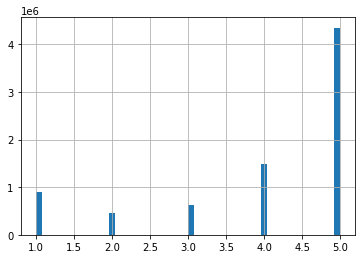

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
df['rating'].hist(bins=50)
#ratings['number_of_ratings'].hist(bins=60)

We can see that the max rating is 5 and mean is 4.01 as per described in the info. 


## 2. Take a subset of the dataset to make it less sparse/ denser. 
( For example, keep the users only who has given 50 or more number of ratings )

In [13]:
min_user_ratings = 50
filter_users = df['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(7824482, 3)
The new data frame shape:	(122171, 3)



## 3. Split the data randomly into train and test dataset. 
( For example, split it in 70/30 ratio)

In [14]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(df_new, test_size = 0.3, random_state = 11)

In [15]:
print("dimension of  train data: {}".format(trainset.shape))
print("dimension of test data: {}".format(testset.shape))

dimension of  train data: (85519, 3)
dimension of test data: (36652, 3)



## 4. Build Popularity Recommender model.

In [16]:
trainset.groupby('product_id')['rating'].mean().head()  

product_id
0594481813    3.0
0970407998    2.5
0972683275    5.0
1400501466    3.0
1400501520    5.0
Name: rating, dtype: float64

In [17]:
trainset.groupby('product_id')['rating'].mean().sort_values(ascending=False).head()  

product_id
B003B3N258    5.0
B001E7498C    5.0
B001E96JBK    5.0
B001E96INY    5.0
B005MLYHWY    5.0
Name: rating, dtype: float64

In [18]:
trainset.groupby('product_id')['rating'].count().sort_values(ascending=False).head()  

product_id
B0088CJT4U    134
B003ES5ZUU    129
B000N99BBC    124
B007WTAJTO    103
B008DWCRQW    102
Name: rating, dtype: int64

In [19]:
ratings_mean_count = pd.DataFrame(trainset.groupby('product_id')['rating'].mean()) 

In [20]:
ratings_mean_count['rating_counts'] = pd.DataFrame(trainset.groupby('product_id')['rating'].count())  

In [21]:
ratings_mean_count.head()  

,rating,rating_counts
product_id,,
0594481813,3.0,1
0970407998,2.5,2
0972683275,5.0,2
1400501466,3.0,3
1400501520,5.0,1


In [22]:
testset.groupby('product_id')['rating'].count().sort_values(ascending=False).head()  

product_id
B0088CJT4U    70
B007WTAJTO    53
B003ES5ZUU    48
B00829TIEK    48
B00829THK0    44
Name: rating, dtype: int64

In [23]:
testset.groupby('product_id')['rating'].mean().sort_values(ascending=False).head()  

product_id
0972683275    5.0
B003YNRWQA    5.0
B003ZSHKIO    5.0
B003ZSHNEA    5.0
B003ZSHNFO    5.0
Name: rating, dtype: float64

In [24]:
ratings_mean_count_test = pd.DataFrame(testset.groupby('product_id')['rating'].mean()) 

In [25]:
ratings_mean_count_test['rating_counts'] = pd.DataFrame(testset.groupby('product_id')['rating'].count())  

In [26]:
ratings_mean_count_test.head()  

,rating,rating_counts
product_id,,
0972683275,5.0,1
1400501466,3.0,2
1400599997,5.0,1
1685560148,5.0,1
3744295508,5.0,1



## 5. Build Collaborative Filtering model. 

In [27]:
reader = Reader()
data = Dataset.load_from_df(df_new[['user_id', 'product_id', 'rating']], reader)

In [28]:
from surprise.model_selection import train_test_split

trainset2, testset2 = train_test_split(data, test_size=0.30, random_state=11)

In [29]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset2)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [30]:
# we can now query for specific predicions
uid = str(196)  # raw user id
iid = str(302)  # raw item id

In [31]:
# get a prediction for specific users and items.
pred = algo.predict(uid, iid, verbose=True)

user: 196        item: 302        r_ui = None   est = 4.27   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [32]:
# run the trained model against the testset
test_pred = algo.test(testset2)

In [33]:
test_pred

[Prediction(uid='A2V2URLB31HG59', iid='B00COEBCXY', r_ui=5.0, est=4.739130434782608, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A2VODABWSVHV8E', iid='B0019UEY66', r_ui=5.0, est=4.265800582326734, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A376OJHLE6SU9Q', iid='B002N8A098', r_ui=5.0, est=4.391752577319588, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A203OCQQ12MAVT', iid='B000MSZQ4K', r_ui=5.0, est=4.265800582326734, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A11ULAZ4B5ZXC8', iid='B00005A1K1', r_ui=5.0, est=4.909090909090909, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1F1A0QQP2XVH5', iid='B0079TOEQQ', r_ui=5.0, est=3.9597563526555715, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A3D822N1K2IAQD', iid='B0093H4WT6', r_ui=5.0, est=3.7123119521573065, details={'actual_k': 2, 'was_impossible': Fal


## 6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [34]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0541


1.0541456656887611


## 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products.

In [35]:
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df_new['product_id'])

# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(df_new.index)
indices[:5]

0    118
1    177
2    178
3    492
4    631
dtype: int64

In [36]:
count_matrix 

<122171x47155 sparse matrix of type '<class 'numpy.int64'>'
	with 122171 stored elements in Compressed Sparse Row format>

In [37]:
c=count_matrix.toarray()

In [38]:
c

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [39]:
type(count_matrix)

scipy.sparse.csr.csr_matrix

In [40]:
print(count_matrix[0,:])

  (0, 0)	1


## 8. Summarise your insights.

This system can be improved by building a Memory-Based Collaborative Filtering based system.  An alternative is to build a Model-based Collaborative Filtering system. This is based on matrix factorization. Matrix factorization is good at dealing with scalability and sparsity than the former. We can then evaluate your model using techniques such as Root Mean Squared Error(RMSE).
Each of our model has some of the issue like cold start, popularity based on only the product and unawareness of the type of electronics item so it would be appropriate to combine and build a Hybrid model recommendation system